For autologging parameters, pytorch lightning is required

In [0]:
pip install pytorch_lightning

Python interpreter will be restarted.
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=fc61a834578b5490d5df6cb6de7b4613458dcdb1332c604db21b20356b04dfe5
  Stored in directory: /root/.cache/pip/wheels/2a/93/86/8cd17bc6c40fb605c3ac549d0b860ef7e84ee5f67bf01a3287
Successfully built fire
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-e022eedc-9793-4386-8342-e9052b992469
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
Python interpreter will be restarted.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import os
import pytorch_lightning as pl

from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchmetrics.functional import accuracy

import mlflow.pytorch
from mlflow import MlflowClient

Initialize DataLoader from MNIST Dataset

In [0]:
train_ds = FashionMNIST(os.getcwd(), train = True,
                        download = True, transform = transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /databricks/driver/FashionMNIST/raw/train-images-idx3-ubyte.gz to /databricks/driver/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /databricks/driver/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /databricks/driver/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /databricks/driver/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /databricks/driver/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /databricks/driver/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /databricks/driver/FashionMNIST/raw



In [0]:
train_ds.classes

Out[3]: ['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [0]:
train_loader = DataLoader(train_ds, batch_size = 32, num_workers = 4)

In [0]:
for inp, label in train_loader:
    print('Input_shape: ',inp.shape)
    print('Labels_shape: ', label.shape)
    break

Input_shape:  torch.Size([32, 1, 28, 28])
Labels_shape:  torch.Size([32])


Showing the Fashion MNIST images of batch size-32

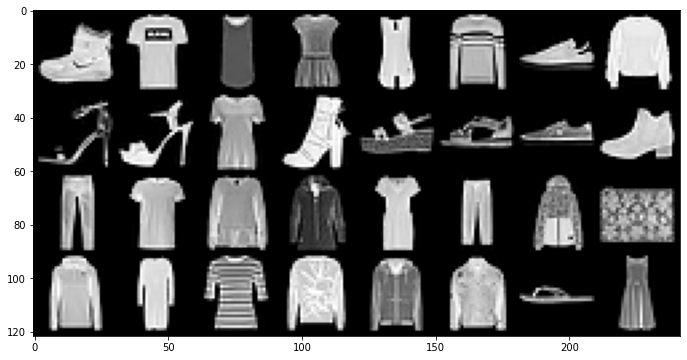

In [0]:
def show_batch_images(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 6))
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break

show_batch_images(train_loader)

For simplicity, here is the simplest most minimal example with just a training
loop step, (no validation, no testing). It illustrates how you can use MLflow
to auto log parameters, metrics, and models.
https://pytorch-lightning.readthedocs.io/en/latest/model/train_model_basic.html
https://www.mlflow.org/docs/latest/python_api/mlflow.pytorch.html#module-mlflow.pytorch

In [0]:
class FMNISTModel(pl.LightningModule):
    def __init__(self):
        super(FMNISTModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_nb):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        pred = logits.argmax(dim = 1)
        acc = accuracy(pred, y)

        self.log('train_loss', loss, on_epoch = True)
        self.log('acc', acc, on_epoch = True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 0.02)

Initializing our model

In [0]:
fmnist_model = FMNISTModel()

fmnist_model

Out[12]: FMNISTModel(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

Creating function to print autologged related informations

In [0]:
def print_auto_logged_info(r):
    
    print('*' * 200)
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith('mlflow.')}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, 'model')]

    print('run_id: {}'.format(r.info.run_id))
    print('artifacts: {}'.format(artifacts))
    print('params: {}'.format(r.data.params))
    print('metrics: {}'.format(r.data.metrics))
    print('tags: {}'.format(tags))

Initializing the Trainer.
Auto logging all MLflow entities while Training the model

In [0]:
trainer = pl.Trainer(max_epochs = 20)

mlflow.pytorch.autolog()

with mlflow.start_run() as run:
    trainer.fit(fmnist_model, train_loader)

print_auto_logged_info(mlflow.get_run(run_id = run.info.run_id))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2022/11/09 12:54:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.

  | Name       | Type      | Params
-----------------------------------------
0 | conv1      | Conv2d    | 260   
1 | conv2      | Conv2d    | 5.0 K 
2 | conv2_drop | Dropout2d | 0     
3 | fc1        | Linear    | 16.1 K
4 | fc2        | Linear    | 510   
-----------------------------------------
21.8 K    Trainable params
0         Non-trainable params
21.8 K    Total params
0.087     Total estimated model params size (MB)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-e022eedc-9793-4386-8342-e9052b992469/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarn

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
2022/11/09 13:01:38 WARNING mlflow.utils.requirements_utils: Found torch version (1.11.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torch==1.11.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/11/09 13:01:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.12.0+cpu) contains a local version label (+cpu). MLflow logged a pip requirement for this package as 'torchvision==0.12.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
************************************************************************************************************************************************************************************************

#### TODO Recording

- Make sure you scroll and show the results
- Click on the "1 run" and open up the run 
- Show "Parameters" and "Metrics"
- Under Artifacts click on Model Summary to show that we have run a CNN